# **RFM ile Müşteri Segmentasyonu (Customer Segmentation with RFM)**

### 1. İş Problemi (Business Problem)
### 2. Veriyi Anlama (Data Understanding)
### 3. Veri Hazırlama (Data Preparation)
### 4. RFM Metriklerinin Hesaplanması (Calculating RFM Metrics)
### 5. RFM Skorlarının Hesaplanması (Calculating RFM Scores)
### 6. RFM Segmentlerinin Oluşturulması ve Analiz Edilmesi (Creating & Analysing RFM Segments)
### 7. Tüm Sürecin Fonksiyonlaştırılması




### **1. İş Problemi (Business Problem)**


Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor.

**Veri Seti Hikayesi**

https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının **01/12/2009 - 09/12/2011** tarihleri arasındaki satışlarını içeriyor. Bu çalışmada 2009-2010 yılları arası incelenecektir.

**Değişkenler**

$\star$  **InvoiceNo:** Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.

$\star$ **StockCode:** Ürün kodu. Her bir ürün için eşsiz numara.

$\star$ **Description:** Ürün ismi

$\star$ **Quantity:** Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.

 $\star$ **InvoiceDate:** Fatura tarihi ve zamanı.

 $\star$ **UnitPrice:** Ürün fiyatı (Sterlin cinsinden)

 $\star$ **CustomerID:** Eşsiz müşteri numarası

 $\star$ **Country:** Ülke ismi. Müşterinin yaşadığı ülke.

### **2. Veriyi Anlama (Data Understanding)**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df_ = pd.read_excel('/content/gdrive/MyDrive/DSMLBC10/week_4 (20.10.22-26.10.22)/rfm/online_retail_II.xlsx', sheet_name = "Year 2009-2010")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Invoice kodu aynı olan bir faturada birden fazla alışveriş yapılmıştır. Quantity üründen kaç adet satıldığını gösteriyor ve Price de birim başına ücreti belirtiyor. Örneğin, müşterinin 12 tane aldığı bir ürün için ne kadar ödediği bulunmalıdır, yani Quantity ile Price çarpımı alınıp ek bir sütun eklenmelidir. Bir faturada **toplam** ne kadar ödendiğini bulmak içinde veri seti tekilleştirilmelidir. 

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(525461, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  U

In [ ]:
df["Description"].nunique()

4681

In [ ]:
df["Description"].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    3549
REGENCY CAKESTAND 3 TIER              2212
STRAWBERRY CERAMIC TRINKET BOX        1843
PACK OF 72 RETRO SPOT CAKE CASES      1466
ASSORTED COLOUR BIRD ORNAMENT         1457
Name: Description, dtype: int64

In [ ]:
df.groupby("Description").agg({"Quantity":"sum"})

,Quantity
Description,
21494,-720
22467,-2
22719,2
DOORMAT UNION JACK GUNS AND ROSES,179
3 STRIPEY MICE FELTCRAFT,690
...,...
wet/smashed/unsellable,-700
wonky bottom/broken,-35
wrong code,-258


quantity eksi bir değer olamaz burada bir sorun var demektir. Şimdilik görmezden gelelim ve veri ön işlemede detaylıca inceleyelim.

In [ ]:
df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head()

,Quantity
Description,
WHITE HANGING HEART T-LIGHT HOLDER,57733
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54698
BROCADE RING PURSE,47647
PACK OF 72 RETRO SPOT CAKE CASES,46106
ASSORTED COLOUR BIRD ORNAMENT,44925


Her bir üründen toplamda ne kadar sipariş verildiği gözlemleniyor.

In [ ]:
df["Invoice"].nunique()

28816

28816 tane fatura kesilmiştir.

In [ ]:
#ürünlerin toplam kazancı örneğin 12 tane ürün her biri 6.95 ise 12*6.95 = 83.4 toplam ücretidir.
df["TotalPrice"] = df["Quantity"] * df["Price"] 
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
#fatura başına toplam harcanan parayı bulma, faturayı tekilleştirme
df.groupby("Invoice").agg({"TotalPrice":"sum"}).head()

,TotalPrice
Invoice,
489434,505.30
489435,145.80
489436,630.33
489437,310.75
489438,2286.24


### **3. Veri Hazırlama (Data Preparation)**

In [ ]:
#eksik verilerimiz vardı oldukça az oldukları için direk uçurmayı tercih ediyoruz.
df.dropna(inplace=True)

RFM de outlier temizliği yapılabilir mi ? Yapılabilir. Fakat burada outlierlar 5 skoruna denk geleceğinden dolayıi aykırı değer olarakta bir baskılama yapsaydıkta aynı değere denk geleceği için aykırı değer için ayrıca bir temizlik yapılmasa da olur.     

In [ ]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0,12.758815,101.220424,-9360.00,2.00,4.00,12.00,19152.00
Price,417534.0,3.887547,71.131797,0.00,1.25,1.95,3.75,25111.09
Customer ID,417534.0,15360.645478,1680.811316,12346.00,13983.00,15311.00,16799.00,18287.00
TotalPrice,417534.0,19.994081,99.915863,-25111.09,4.25,11.25,19.35,15818.40


quantity değerinde min -9360.00 iken %25 lik dilimde 2 aynı şekilde max ve bir önceki değeri arasında da uçurum söz konusu yani ciddi bir outlier var demektir. Fiyat eksi değer olamayacağı için aslında bunlar C ile başlayan iade değerlerdir. Bunları faturadan uçurmak gerekir.

In [ ]:
df = df[~df["Invoice"].str.contains("C", na = False)] #C 'yi içerenler haricindekileri getir. C sizler yani.

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


### **4. RFM Metriklerinin Hesaplanması (Calculating RFM Metrics)**

#### **Recency :** Müşterinin yeniliğini ifade eder. Matematiksel karşılığı, 
analizin yapıldığı tarih - ilgili müşterinin son satın alma tarihi
#### **Frequency :** Müşterinin yaptığı toplam satın almadır.
#### **Monetary :** Müşterinin yaptığı bu toplam satın almalar neticesinde bıraktığı toplam parasal değerdir. 

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
df["InvoiceDate"].max()

Timestamp('2010-12-09 20:01:00')

In [ ]:
import datetime as dt

In [ ]:
# max tarih üzerinden 2 gün sonrasını al ki min fark 2 olsun. Recency değeri için.
today_date = dt.datetime(2010, 12, 11)
type(today_date)

datetime.datetime

In [ ]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
rfm

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93
...,...,...,...
18283.0,18,6,641.77
18284.0,67,1,461.68
18285.0,296,1,427.00


In [ ]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [ ]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4314.0,91.269819,96.944304,1.0,18.00,53.00,136.0000,374.00
frequency,4314.0,4.454103,8.168658,1.0,1.00,2.00,5.0000,205.00
monetary,4314.0,2047.288659,8912.523243,0.0,307.95,705.55,1722.8025,349164.35


In [ ]:
rfm = rfm[rfm["monetary"] > 0] # monetary 0 değeri geldi pek mantıklı olmadı için 0 dan büyük diye seçebiliriz.
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4312.0,91.172542,96.861457,1.00,18.0000,53.00,136.0000,374.00
frequency,4312.0,4.455705,8.170213,1.00,1.0000,2.00,5.0000,205.00
monetary,4312.0,2048.238236,8914.481280,2.95,307.9875,706.02,1723.1425,349164.35


In [ ]:
rfm.shape

(4312, 3)

Şu an 4312 tane gözlem birimi var ve 3 tane metriğimiz mevcut bunu skorlara çevirmemiz gerekmektedir.

### **5. RFM Skorlarının Hesaplanması (Calculating RFM Scores)**

**Recency** müşterinin bizden en son ne zaman alışveriş yaptığı durumu ifade etmektedir. Örneğin recency değeri 1 ise en son 1 gün önce alışveriş yapıldığını anlarız. Benzer şekilde 10 ise 10 gün önce alışveriş yapılmıştır. Bizim için ne kadar az ise o kadar iyidir. Az olana 5 puan verirken, çok olana 1 puan vereceğiz.

**Frequency** müşterinin yaptığı işlem (alışveriş) sayısıdır. Ne kadar fazla ise o kadar iyidir. Az olana 1 puan verirken, çok olana 5 puan vereceğiz.

**Monetary** parasal değeri ifade eder. Ne kadar fazla ise o kadar iyidir. Az olana 1 puan verirken, çok olana 5 puan vereceğiz.

In [ ]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
#qcut da quantile bir değişkeni küçükten büyüğe sıralar. O yüzden Recency değeri,
#az olana 5 vereceğimiz için labellar 5 ten azalarak yazılmıştır.
#örneğin elinde 0 dan 100 e kadar olan değerler var qcut bunu 
#0-20, 20-40, 40-60, 60-80, 80-100 bölüyor sonrada labellarla eşleştiriyor.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
rfm.head()

,recency,frequency,monetary,recency_score
Customer ID,,,,
12346.0,165,11,372.86,2
12347.0,3,2,1323.32,5
12348.0,74,1,222.16,2
12349.0,43,3,2671.14,3
12351.0,11,1,300.93,5


In [ ]:
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

#rank methof first diyerek ilk gördüğünü ilk sınıfa ata diyoruz. Bunu yazmazsak value error hatası alıyoruz.
#oluşturulan aralıklarda unique değerler yer almadığı için bu hatayı alıyoruz.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score
Customer ID,,,,,
12346.0,165,11,372.86,2,5
12347.0,3,2,1323.32,5,2
12348.0,74,1,222.16,2,1
12349.0,43,3,2671.14,3,3
12351.0,11,1,300.93,5,1


In [ ]:
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score
Customer ID,,,,,,
12346.0,165,11,372.86,2,5,2
12347.0,3,2,1323.32,5,2,4
12348.0,74,1,222.16,2,1,1
12349.0,43,3,2671.14,3,3,5
12351.0,11,1,300.93,5,1,2


In [ ]:
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))
rfm.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0,165,11,372.86,2,5,2,25
12347.0,3,2,1323.32,5,2,4,52
12348.0,74,1,222.16,2,1,1,21
12349.0,43,3,2671.14,3,3,5,33
12351.0,11,1,300.93,5,1,2,51


Skorlamak demek hepsini aynı cinsten ifade etmek demek, yani standartlaştırmak demek. Hem kendi içinde hem de birbirleriyle kıyaslanabilir hale getirmek demektir. Paradan ziyade müşteri ile iletişimin kuvvetli olması bizim için önemli olduğundan monetary değerine bu aşamada bakılmaz. 

In [ ]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4312.0,91.172542,96.861457,1.00,18.0000,53.00,136.0000,374.00
frequency,4312.0,4.455705,8.170213,1.00,1.0000,2.00,5.0000,205.00
monetary,4312.0,2048.238236,8914.481280,2.95,307.9875,706.02,1723.1425,349164.35


In [ ]:
rfm[rfm["RFM_SCORE"] == "55"] # R:5 F:5 #champions

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12415.0,11,7,19543.84,5,5,5,55
12431.0,9,13,4370.52,5,5,5,55
12471.0,10,49,20139.74,5,5,5,55
12472.0,5,13,11308.48,5,5,5,55
12474.0,14,13,5048.66,5,5,5,55
...,...,...,...,...,...,...,...
18225.0,1,15,7545.14,5,5,5,55
18226.0,14,15,6650.83,5,5,5,55
18229.0,2,10,3526.81,5,5,5,55


In [ ]:
rfm[rfm["RFM_SCORE"] == "11"] # R:1 F:1 #hibernating

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12355.0,203,1,488.21,1,1,2,11
12362.0,374,1,130.00,1,1,1,11
12366.0,269,1,500.24,1,1,2,11
12368.0,264,1,917.70,1,1,3,11
12378.0,198,1,1407.70,1,1,4,11
...,...,...,...,...,...,...,...
15928.0,292,1,293.53,1,1,2,11
15929.0,280,1,594.00,1,1,3,11
15941.0,273,1,405.00,1,1,2,11


### **6. RFM Segmentlerinin Oluşturulması ve Analiz Edilmesi (Creating & Analysing RFM Segments)**

Daha okunabilir hale getirmek için aşağıdaki tablo gibi numaralara karşılık gelen segment isimlerine ayrılacaktır.

regex kullanırak segmentlere ayrılacak.



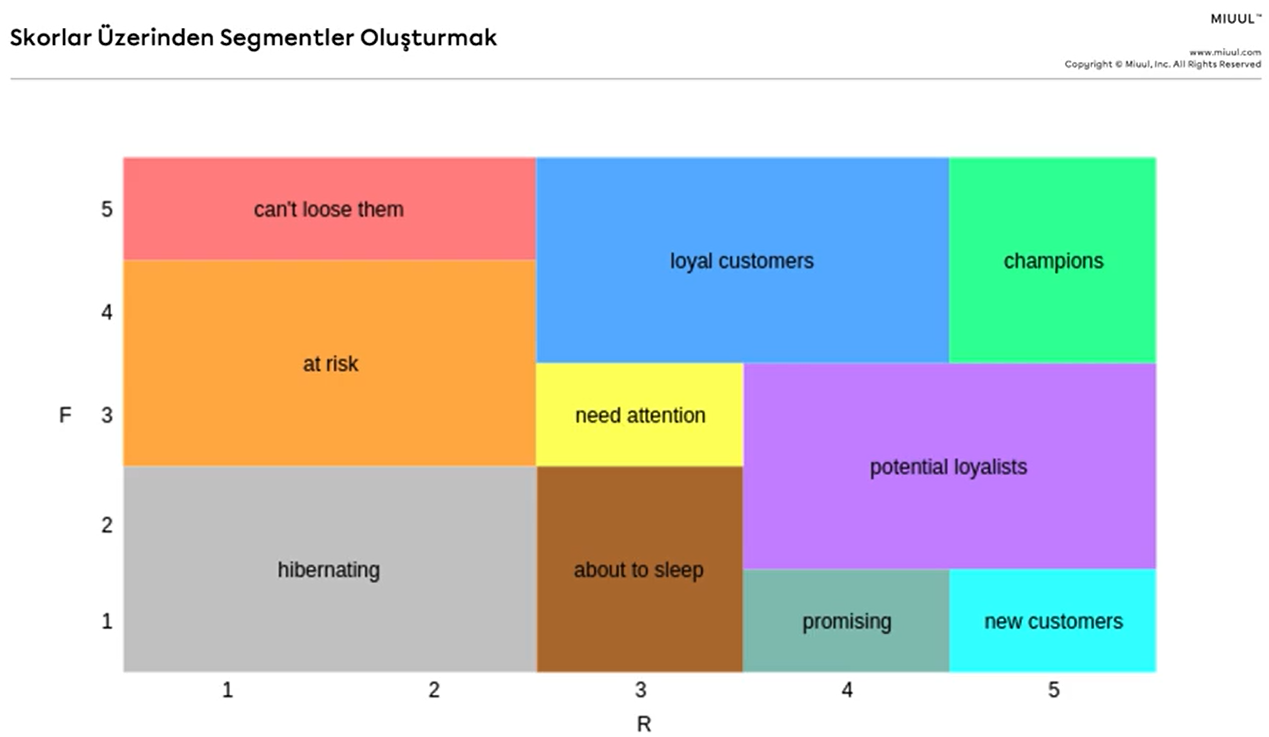

In [ ]:
  seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }
rfm["segment"] = rfm["RFM_SCORE"].replace(seg_map, regex=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12346.0,165,11,372.86,2,5,2,25,cant_loose
12347.0,3,2,1323.32,5,2,4,52,potential_loyalists
12348.0,74,1,222.16,2,1,1,21,hibernating
12349.0,43,3,2671.14,3,3,5,33,need_attention
12351.0,11,1,300.93,5,1,2,51,new_customers


In [ ]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean","count"])

recency        frequency           monetary      
                           mean count       mean count         mean count
segment                                                                  
about_to_sleep        53.819242   343   1.201166   343   441.320000   343
at_risk              152.158756   611   3.073650   611  1188.878316   611
cant_loose           124.116883    77   9.116883    77  4099.450000    77
champions              7.119155   663  12.553544   663  6852.264167   663
hibernating          213.885714  1015   1.126108  1015   403.977836  1015
loyal_customers       36.287062   742   6.830189   742  2746.067353   742
need_attention        53.265700   207   2.449275   207  1060.357005   207
new_customers          8.580000    50   1.000000    50   386.199200    50
potential_loyalists   18.793037   517   2.017408   517   729.510986   517
promising             25.747126    87   1.000000    87   367.086782    87

Aslında yukarıdaki tabloda işimiz bitti sayılır. Fakat bizden özel olarak bir segmentin raporlanması istenirse aşağıdaki adımları uygulamalısın.

In [ ]:
rfm[rfm["segment"] == "cant_loose"].head()
rfm[rfm["segment"] == "cant_loose"].index

Float64Index([12346.0, 12380.0, 12482.0, 12510.0, 12891.0, 12932.0, 13044.0,
              13313.0, 13680.0, 13782.0, 13799.0, 13856.0, 14025.0, 14063.0,
              14160.0, 14221.0, 14548.0, 14607.0, 14685.0, 14745.0, 15003.0,
              15013.0, 15015.0, 15125.0, 15141.0, 15222.0, 15306.0, 15321.0,
              15359.0, 15369.0, 15372.0, 15443.0, 15538.0, 15607.0, 15633.0,
              15722.0, 15751.0, 15754.0, 15768.0, 15911.0, 15912.0, 16027.0,
              16032.0, 16158.0, 16177.0, 16197.0, 16335.0, 16467.0, 16631.0,
              16742.0, 16743.0, 16875.0, 16986.0, 17021.0, 17032.0, 17092.0,
              17113.0, 17157.0, 17188.0, 17230.0, 17268.0, 17426.0, 17448.0,
              17454.0, 17512.0, 17578.0, 17602.0, 17651.0, 17940.0, 17969.0,
              17988.0, 18009.0, 18051.0, 18064.0, 18094.0, 18251.0, 18258.0],
             dtype='float64', name='Customer ID')

In [ ]:
new_df = pd.DataFrame()
new_df["new_customer_id"] = rfm[rfm["segment"] == "new_customers"].index

In [ ]:
new_df["new_customer_id"] = new_df["new_customer_id"].astype(int)

In [ ]:
new_df.head()

,new_customer_id
0,12351
1,12385
2,12386
3,12427
4,12441


In [ ]:
#new_df.to_csv("new_customers.csv") #csv dosyasına dönüşüm yaptık.

In [ ]:
#rfm.to_csv("rfm.csv") #oluşturulan RFM'i de ayrı bir csv dosyası olarak dışarı çıkardık.

### **7. Tüm Sürecin Fonksiyonlaştırılması (Functionalization)**
Just do someting.

Don't repeat yourself (DRY).

In [ ]:
def create_rfm(dataframe, csv=False):

    # VERIYI HAZIRLAMA
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]

    # RFM METRIKLERININ HESAPLANMASI
    today_date = dt.datetime(2011, 12, 11)
    rfm = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                                'Invoice': lambda num: num.nunique(),
                                                "TotalPrice": lambda price: price.sum()})
    rfm.columns = ['recency', 'frequency', "monetary"]
    rfm = rfm[(rfm['monetary'] > 0)]

    # RFM SKORLARININ HESAPLANMASI
    rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

    # cltv_df skorları kategorik değere dönüştürülüp df'e eklendi
    rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                        rfm['frequency_score'].astype(str))
    
    # SEGMENTLERIN ISIMLENDIRILMESI
    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

    rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
    rfm = rfm[["recency", "frequency", "monetary", "segment"]]
    rfm.index = rfm.index.astype(int)

    if csv:
        rfm.to_csv("rfm.csv")
        
    return rfm

In [ ]:
df = df_.copy()
df.head() #fonksiyonun ilk hali

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
rfm_new = create_rfm(df)
rfm_new.head()

,recency,frequency,monetary,segment
Customer ID,,,,
12346,530,11,372.86,cant_loose
12347,368,2,1323.32,potential_loyalists
12348,439,1,222.16,hibernating
12349,408,3,2671.14,need_attention
12351,376,1,300.93,new_customers


Drive ile elde edilen dataframei csv dosyasına dönüştürme. 

In [ ]:
rfm_new.to_csv('rfm_new.csv')
!cp rfm_new.csv "/content/gdrive/MyDrive/DSMLBC10/week_4 (20.10.22-26.10.22)/rfm"